In [1]:
import numpy as np
import pandas as pd
import datetime


df_heat = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/external/cs_cart_heats.csv', sep = ',', converters={'product_id':str,'ym_client_id':str})
# df_heat['ym_client_id'] = df_heat['ym_client_id'].astype(str)
cart = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/external/cs_cart_carts.csv',sep = ',',converters={'product_id':str})
users = pd.read_json('/Users/kuznetsovnikita/recommendations/data/external/сs_cart_users.json')
vygruz = pd.read_csv('/Users/kuznetsovnikita/PycharmProjects/pythonProject1/downloaded_file1.csv', sep=',',converters={'id':str})


In [2]:
# процент активных пользователей
act_users = users.loc[users.check_week == 'Заходил в течении недели'].shape[0]/users.shape[0]

In [3]:
cart['product_id'] = cart['product_id'].replace('',np.nan,regex= False).astype(float)
vygruz.cumdate = pd.to_datetime(vygruz.cumdate, infer_datetime_format=True)
vygruz.loc[:,['days_in_stock']] = (pd.to_datetime('2021-10-10')-vygruz.cumdate).dt.days
vygruz.loc[:,['discount']] =np.where(vygruz['Цена со скидкой'].isna(), 0,(vygruz['Цена шоурум']-vygruz['Цена со скидкой'])/vygruz['Цена шоурум'])
vygruz = vygruz.loc[vygruz.id != '']
vygruz.id = vygruz.id.replace(' ','',regex=True)

# vygruz.loc[~vygruz['Цена со скидкой'].isna()].loc[:,['Цена со скидкой','Цена шоурум','discount']]

In [4]:
## потоварная статистика
products = df_heat.loc[(df_heat.product_id != '0')&(df_heat.product_id != '16777215')] #выкидываю технические неполадки
# products = products.loc[(products['product_id'].apply(type) == int)] 
rating = products.groupby(['product_id'])['_id'].count().reset_index().sort_values('_id', ascending=False)

rating

,product_id,_id
1248,2000000068053,242
3008,2000000107837,209
1574,2000000077789,200
1074,2000000062983,187
2283,2000000097312,154
...,...,...
187,2000000016894,1
1497,2000000075372,1
1495,2000000075327,1
1490,2000000075259,1


<AxesSubplot:xlabel='categ'>

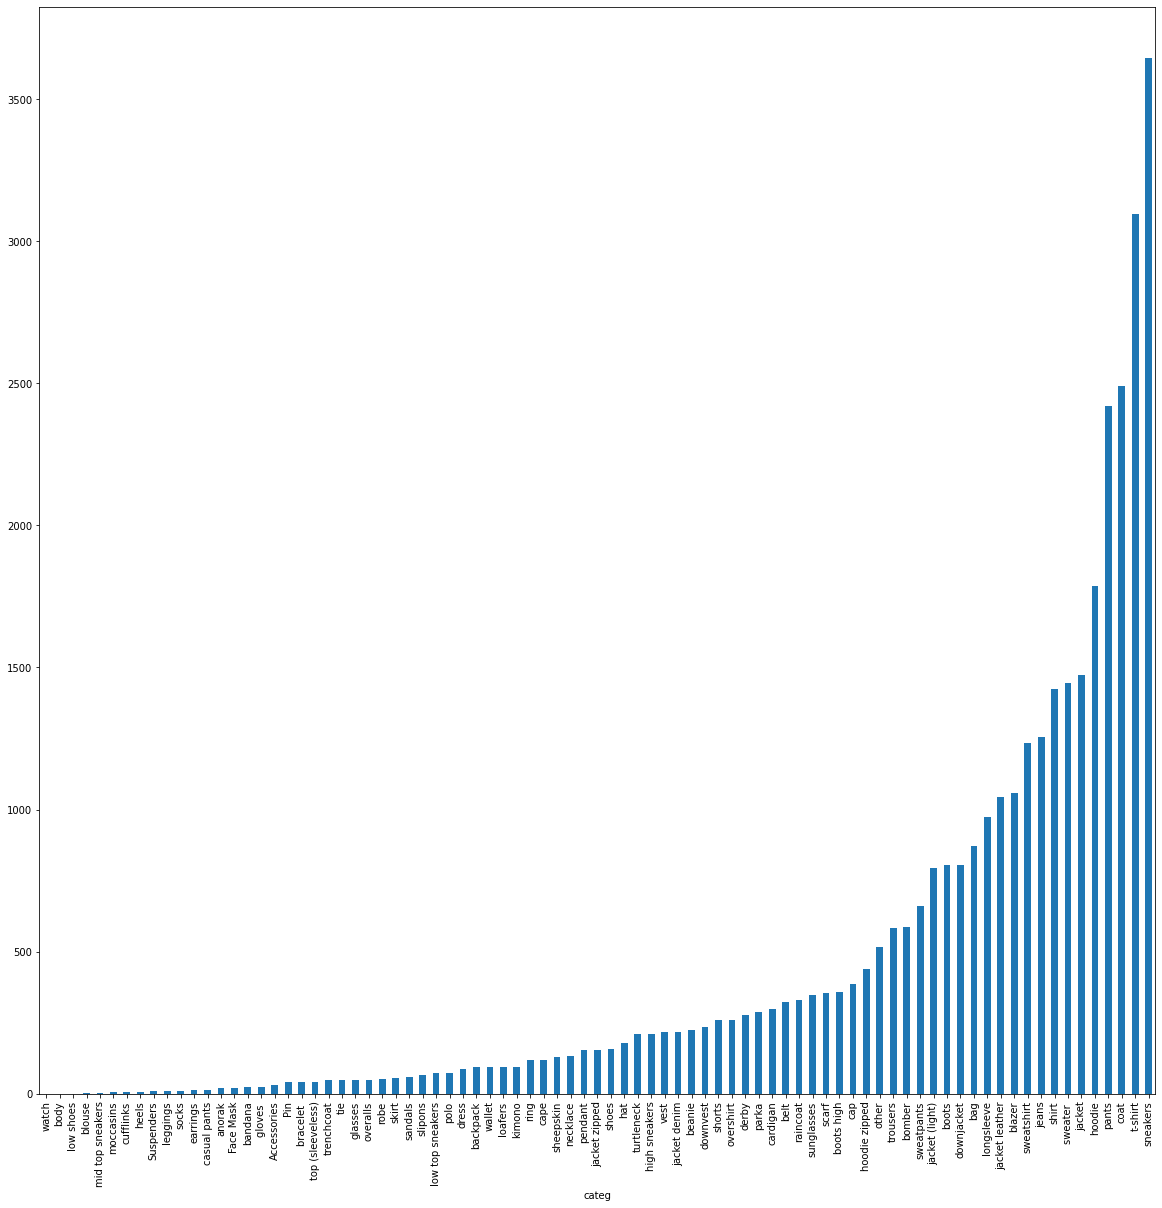

In [5]:
# добавляю всю информацию по каждой вещи
rating_full = rating.merge(vygruz, how = 'left', left_on='product_id', right_on='id')
# график с просмотрам по каждой категории товаров
rating_full.loc[:,['_id','categ']].groupby('categ')['_id'].sum().sort_values().plot(kind = 'bar', figsize = (20,20))

In [60]:
rating.merge(vygruz, how='left', left_on='product_id', 
             right_on='id').loc[:,['id','_id','days_in_stock','Цена шоурум','discount','categ','cond']].to_csv('rating_for_lm.csv')

In [14]:
cart.product_id.dropna().sort_values()

767     2.000000e+12
1463    2.000000e+12
815     2.000000e+12
902     2.000000e+12
383     2.000000e+12
            ...     
395     2.000000e+12
1171    2.000000e+12
723     2.000000e+12
1440    2.000000e+12
176     2.000000e+12
Name: product_id, Length: 1481, dtype: float64

<AxesSubplot:xlabel='categ'>

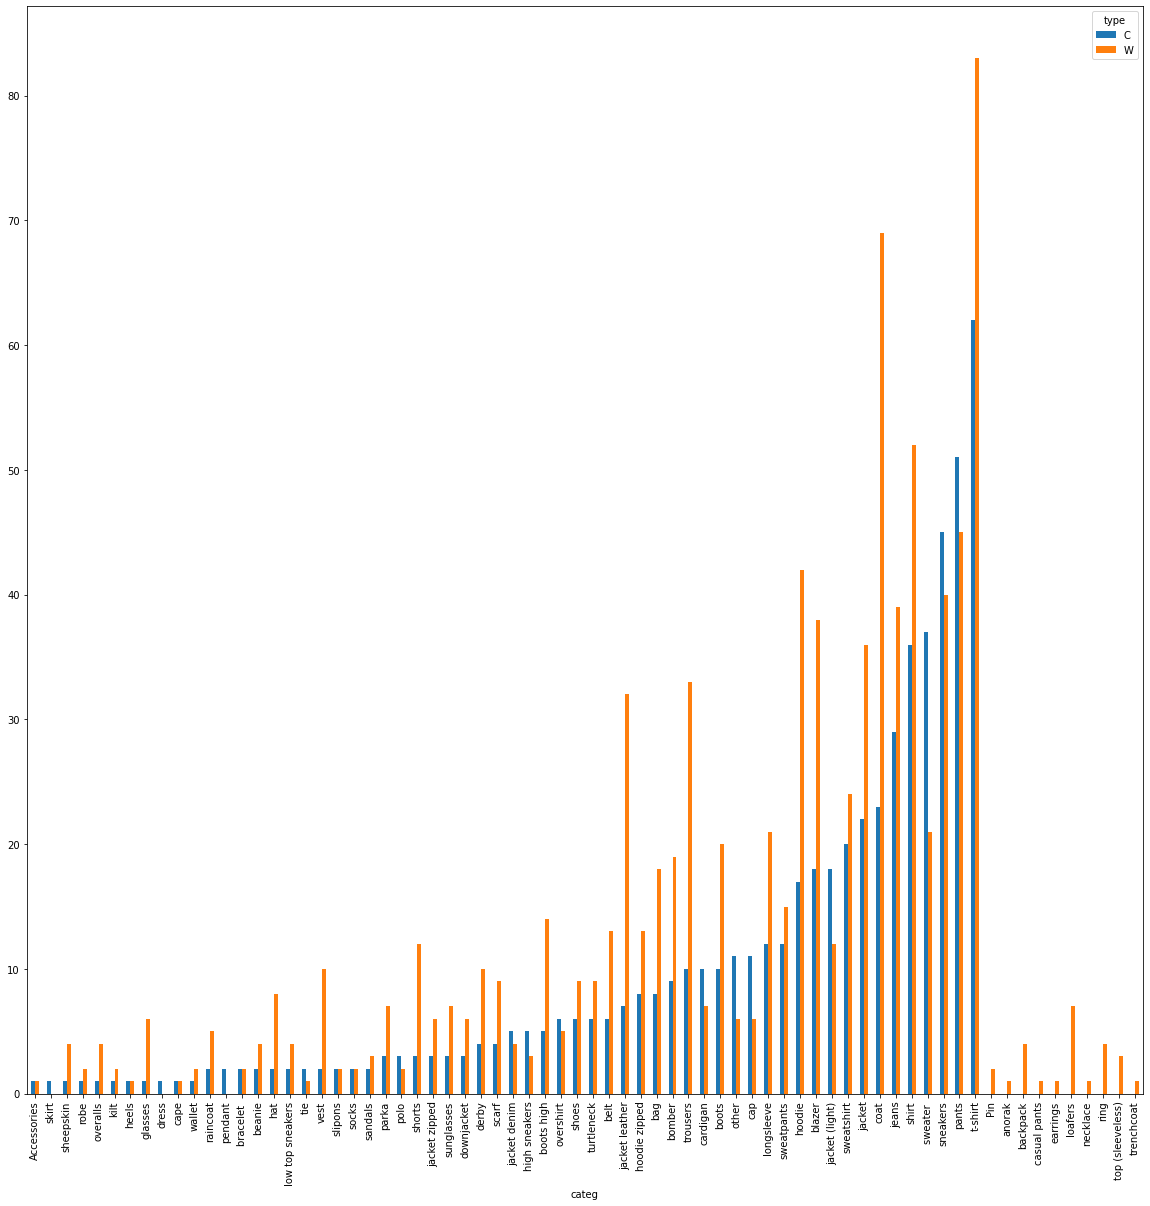

In [22]:
# теперь аналогично посмотрим на добавления в корзину/вишлисты
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False).astype(int)
cart = cart.dropna(subset = ['product_id'])
cart.loc[:,['product_id']] = cart.product_id.astype(int)

cart_full = cart.merge(vygruz.loc[:,['id','categ']], how='left', left_on='product_id', right_on='id')

cart_full_gb = cart_full.groupby(['type','categ'])['id'].count().reset_index()
cart_full_piv = cart_full_gb.sort_values(['type','id'], 
                                         ascending=[True, False]).pivot(columns = ['type'], 
                                                                        index = 'categ',
                                                                        values = 'id')
# сменить на барплоты!

cart_full_piv.sort_values('C').plot(kind = 'bar',subplots = False, layout = (2,1), figsize = (20,20), legend = True)


In [23]:
# достаю списки товаров из корзин/вишлистов/заказов каждого клиента
cart_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'W')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
wish_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'C')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
# засовываю в единый фрейм с учетом непересечений
cart_wish_user_prod = cart_user_prod.join(wish_user_prod, 
                                          how = 'outer', 
                                          on ='ym_client_id', 
                                          lsuffix = '_cart', 
                                          rsuffix = '_wish').drop_duplicates('ym_client_id').reset_index().drop(columns = 'index')
cart_wish_user_prod
# wish_user_prod

,ym_client_id,product_id_cart,product_id_wish
0,1586517765142996502,"[2000000079578, 2000000071244]","[2000000098067, 2000000109862]"
1,1592847484780941724,[2000000040967],NaN
2,15945421401032860445,[2000000103075],NaN
3,1594795295110685242,"[2000000071398, 2000000087337]",NaN
4,15958550101040682370,[2000000077543],"[2000000077482, 2000000039305, 2000000076768, ..."
...,...,...,...
276,1636982316555187308,NaN,[2000000111490]
277,16369850231023857224,NaN,[2000000109916]
278,16369870389189877,NaN,[2000000105345]
279,1637013291942414276,NaN,[2000000066059]


In [33]:
# создаю матрицу предпочтений по трем видам (пока что) оценок: просмотр товара, добавление в корзину/вишлист, добавление в заказ
products['ym_client_id'] = products['ym_client_id'].astype(str)
products = products.loc[products.product_id != 'NaN']

# делаю список со всеми возможными вещами, обрезать по наличию буду потом
all_items = np.concatenate([products.product_id.unique(),cart.product_id.astype(str).unique()])
product_id_cols = [str(i) for i in all_items]
product_id_cols.extend(['product_id_wish','product_id_cart','product_id', 'ym_client_id'])
product_id_cols.reverse()

user_product_heat = products.groupby('ym_client_id')['product_id'].apply(list).reset_index()
user_product_heat = user_product_heat.merge(cart_wish_user_prod, how ='outer', on = 'ym_client_id')
user_product_heat = user_product_heat.reindex(columns=product_id_cols, fill_value=0).set_index('ym_client_id')
user_product_heat = user_product_heat.loc[:,~user_product_heat.columns.duplicated()]
user_product_heat.fillna({'product_id':'', 'product_id_cart':'', 'product_id_wish':''}, inplace=True)

# заполняю матрицу предпочтений ранжированными значениями (!!запихнуть в функцию потом!!)
for i in range(user_product_heat.shape[0]):
    if type(user_product_heat.loc[:,'product_id'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 1
    if type(user_product_heat.loc[:,'product_id_cart'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id_cart'].iat[i]:
            
            user_product_heat[f'{product}'].iat[i] += 10
    if type(user_product_heat.loc[:,'product_id_wish'].iat[i])== list:
        for product in user_product_heat.loc[:,'product_id_wish'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 5

user_product_heat.drop(columns = ['product_id','product_id_cart','product_id_wish'], inplace = True)

#после этого, по сути, надо дропнуть вещи, которые уже архивные

user_product_heat

,2000000090177,2000000018416,2000000046327,2000000109800,2000000018447,2000000054926,2000000057118,2000000102214,2000000078571,2000000073200,...,2000000013916,2000000060514,2000000075310,2000000082929,2000000075181,2000000063423,2000000093321,2000000094601,2000000099705,2000000076294
ym_client_id,,,,,,,,,,,,,,,,,,,,,
1586517765142996502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586839436824718143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586877094630823534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587480513689496288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587732076104489525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636565996279441450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636633848855834481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636831744489564480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
vygruz.loc[:,['id_s']] = vygruz.id.astype(str)
combinations = {
    1:['categ'],
    2:['brand'],
    3:['categ','brand'],
    4:['brand','Группа категорий']
}



In [104]:
dict_combs = {}
for num, comb in combinations.items():
    cols = ['id_s']
    cols.extend(comb)
    brand_categ = user_product_heat.T.merge(vygruz.loc[:,cols], how='left',left_on = user_product_heat.T.index,right_on='id_s')
    stock = vygruz.loc[vygruz.reason == 'Приемка'].groupby(comb)['id_s'].count()
    
    dict_combs[num] = brand_categ.groupby(comb).sum()
    dict_combs[num] = dict_combs[num].join(stock)
    dict_combs[num] = dict_combs[num].loc[~((dict_combs[num].id_s.isna())|(dict_combs[num].id_s ==1))]
#     dict_combs[tuple(comb)].append(dict_combs[tuple(comb)].sum(numeric_only=True), ignore_index=True)


In [107]:
dict_combs[4]

1586517765142996502  \
brand                     Группа категорий                            
1017 ALYX 9SM             Куртки и пуховики                       0   
                          Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Рубашки                                 0   
                          Штаны и брюки                           0   
...                                                             ...   
Ziggy Chen                Пальто и плащи                          0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
kaval                     Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1586839436824718143  \
brand                     Группа категорий                            
1017 ALYX 9SM             Куртки и пуховики                       0   
                          Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Рубашки                                 0   
                          Штаны и брюки                           0   
...                                                             ...   
Ziggy Chen                Пальто и плащи                          0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
kaval                     Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1586877094630823534  \
brand                     Группа категорий                            
1017 ALYX 9SM             Куртки и пуховики                       0   
                          Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Рубашки                                 0   
                          Штаны и брюки                           0   
...                                                             ...   
Ziggy Chen                Пальто и плащи                          0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
kaval                     Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1587480513689496288  \
brand                     Группа категорий                            
1017 ALYX 9SM             Куртки и пуховики                       0   
                          Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Рубашки                                 0   
                          Штаны и брюки                           0   
...                                                             ...   
Ziggy Chen                Пальто и плащи                          0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
kaval                     Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1587732076104489525  \
brand                     Группа категорий                            
1017 ALYX 9SM             Куртки и пуховики                       0   
                          Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0 

In [34]:
user_product_heat.iloc[0,3:].unique()

array([ 0,  5,  1,  2,  4, 11, 10])

In [77]:
dict_combs[('brand','categ')].append(dict_combs[('brand','categ')].sum(numeric_only=True), ignore_index=True)
dict_combs[('brand','categ')].loc[~((dict_combs[('brand','categ')].id_s.isna())|(dict_combs[('brand','categ')].id_s ==1))]
# dict_combs.keys()

1586517765142996502  \
brand                     categ                             
1017 ALYX 9SM             t-shirt                       0   
10sei0otto                sweater                       0   
11 By Boris Bidjan Saberi pants                         0   
A Cold Wall               coat                          0   
                          t-shirt                       0   
...                                                   ...   
Ziggy Chen                longsleeve                    0   
                          pants                         0   
                          sweater                       0   
kaval                     pants                         0   
ВЛАД ВЫСОЦКИЙ             other                         0   

                                      1586839436824718143  \
brand                     categ                             
1017 ALYX 9SM             t-shirt                       0   
10sei0otto                sweater                       0   
11 By Boris Bidjan Saberi pants                         0   
A Cold Wall               coat                          0   
                          t-shirt                       0   
...                                                   ...   
Ziggy Chen                longsleeve                    0   
                          pants                         0   
                          sweater                       0   
kaval                     pants                         0   
ВЛАД ВЫСОЦКИЙ             other                         0   

                                      1586877094630823534  \
brand                     categ                             
1017 ALYX 9SM             t-shirt                       0   
10sei0otto                sweater                       0   
11 By Boris Bidjan Saberi pants                         0   
A Cold Wall               coat                          0   
                          t-shirt                       0   
...                                                   ...   
Ziggy Chen                longsleeve                    0   
                          pants                         0   
                          sweater                       0   
kaval                     pants                         0   
ВЛАД ВЫСОЦКИЙ             other                         0   

                                      1587480513689496288  \
brand                     categ                             
1017 ALYX 9SM             t-shirt                       0   
10sei0otto                sweater                       0   
11 By Boris Bidjan Saberi pants                         0   
A Cold Wall               coat                          0   
                          t-shirt                       0   
...                                                   ...   
Ziggy Chen                longsleeve                    0   
                          pants                         0   
                          sweater                       0   
kaval                     pants                         0   
ВЛАД ВЫСОЦКИЙ             other                         0   

                                      1587732076104489525  \
brand                     categ                             
1017 ALYX 9SM             t-shirt                       0   
10sei0otto                sweater                       0   
11 By Boris Bidjan Saberi pants                         0   
A Cold Wall               coat                          0   
                          t-shirt                       0   
...                                                   ...   
Ziggy Chen                longsleeve                    0   
                          pants                         0   
                          sweater                       0   
kaval                     pants                         0   
ВЛАД ВЫСОЦКИЙ             other                         0   

                                      1587819907779396547  \
brand  

In [84]:
dict_combs[('brand','categ')].append(dict_combs[('brand','categ')].sum(), ignore_index=True).T.sort_values(1964)

,0,1,2,3,4,5,6,7,8,9,...,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964
1636017680639879074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636017687115318232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636017753386479644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636017787114369102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163535361863429089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637014036749199126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0
163429089511800962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,337.0
1614613683850071709,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0
1632300479943213942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,785.0


In [99]:
df_heat.loc[df_heat.user_id != 0].groupby(['user_id','ym_client_id'])['_id'].count()

user_id  ym_client_id       
1        1586517765142996502    68
         1591701810230119000    55
         1614333203141223820    22
         1615200562371260127    15
         1620304476826610523    55
                                ..
11915    1636896693340214859     5
11916    1636909231983932341     3
11920    1636959895372990215    84
11923    1636990611841765374     3
11924    1636998565127904306    45
Name: _id, Length: 394, dtype: int64